
# Ранняя остановка в Gradient Boosting

Градиентный бустинг  — это ансамблевый метод, сочетающий в себе несколько слабых
классификаторов, обычно это деревья решений, чтобы создать надежную и мощную
прогнозирующая модель. Это происходит итеративно, где каждый новый этап
(дерево) исправляет ошибки предыдущих.Это основная идея градиентного бустинга.

Ранняя остановка — это метод градиентного бустинга , который позволяет нам находить
оптимальное количество итераций, необходимое для построения модели, обобщающей
хорошо работает с невидимыми данными и позволяет избежать переобучения. Основна идея заключается в следующем: Создаем отложенную выборку, т.е. часть своих данных мы отложим в качестве набора проверки (указанного с помощью
`validation_fraction`) для оценки производительности модели во время обучения.
Поскольку модель строится итеративно с дополнительными этапами (деревьями), ее
производительность проверочного набора контролируется как функция
количество шагов.

Ранняя остановка становится эффективной, когда производительность модели на
набор проверки выходит на плато или ухудшается (в пределах отклонений, указанных в `tol`)
за определенное количество последовательных этапов (указанных `n_iter_no_change`).
Это сигнализирует о том, что модель достигла точки, когда дальнейшие итерации могут быть невозможны.
приводят к переобучению, и пора прекращать тренировки.

Количество оценок (деревьев) в окончательной модели при ранней остановке.
Доступ к ним можно получить с помощью атрибута n_estimators_. В общем, рано
остановка — ценный инструмент для достижения баланса между производительностью модели и
эффективность повышения градиента.




## Подготовка данных
Сначала мы загружаем и готовим набор данных о ценах на жилье в Калифорнии для
обучение и оценка. Он подмножества набора данных, разбивает его на обучение
и наборы проверки.



In [1]:
import time

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

data = fetch_california_housing()
X, y = data.data[:600], data.target[:600]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение и сравнение моделей
Обучаются две модели :class:`~sklearn.ensemble.GradientBoostingRegressor`:
один с другим без ранней остановки. Цель – сравнить их
производительность. Он также вычисляет время обучения и `n_estimators_`
используется обеими моделями.



In [2]:
params = dict(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=42)

gbm_full = GradientBoostingRegressor(**params)
gbm_early_stopping = GradientBoostingRegressor(
    **params,
    validation_fraction=0.1,
    n_iter_no_change=10,
)

start_time = time.time()
gbm_full.fit(X_train, y_train)
training_time_full = time.time() - start_time
n_estimators_full = gbm_full.n_estimators_

start_time = time.time()
gbm_early_stopping.fit(X_train, y_train)
training_time_early_stopping = time.time() - start_time
estimators_early_stopping = gbm_early_stopping.n_estimators_

## Ошибка расчета
Код вычисляет :func:`~sklearn.metrics.mean_squared_error` для обоих
наборы данных обучения и проверки для моделей, обученных в предыдущем
раздел. Он вычисляет ошибки для каждой итерации повышения. Цель
оценить производительность и сходимость моделей.



In [3]:
train_errors_without = []
val_errors_without = []

train_errors_with = []
val_errors_with = []

for i, (train_pred, val_pred) in enumerate(
    zip(
        gbm_full.staged_predict(X_train),
        gbm_full.staged_predict(X_val),
    )
):
    train_errors_without.append(mean_squared_error(y_train, train_pred))
    val_errors_without.append(mean_squared_error(y_val, val_pred))

for i, (train_pred, val_pred) in enumerate(
    zip(
        gbm_early_stopping.staged_predict(X_train),
        gbm_early_stopping.staged_predict(X_val),
    )
):
    train_errors_with.append(mean_squared_error(y_train, train_pred))
    val_errors_with.append(mean_squared_error(y_val, val_pred))

## Визуализируйте сравнение
Он включает в себя три подсюжета:

1. Построение графика ошибок обучения обеих моделей на итерациях повышения.
2. Построение графика ошибок проверки обеих моделей на итерациях повышения.
3. Создание гистограммы для сравнения времени обучения и используемого средства оценки.
 моделей с ранней остановкой и без нее.




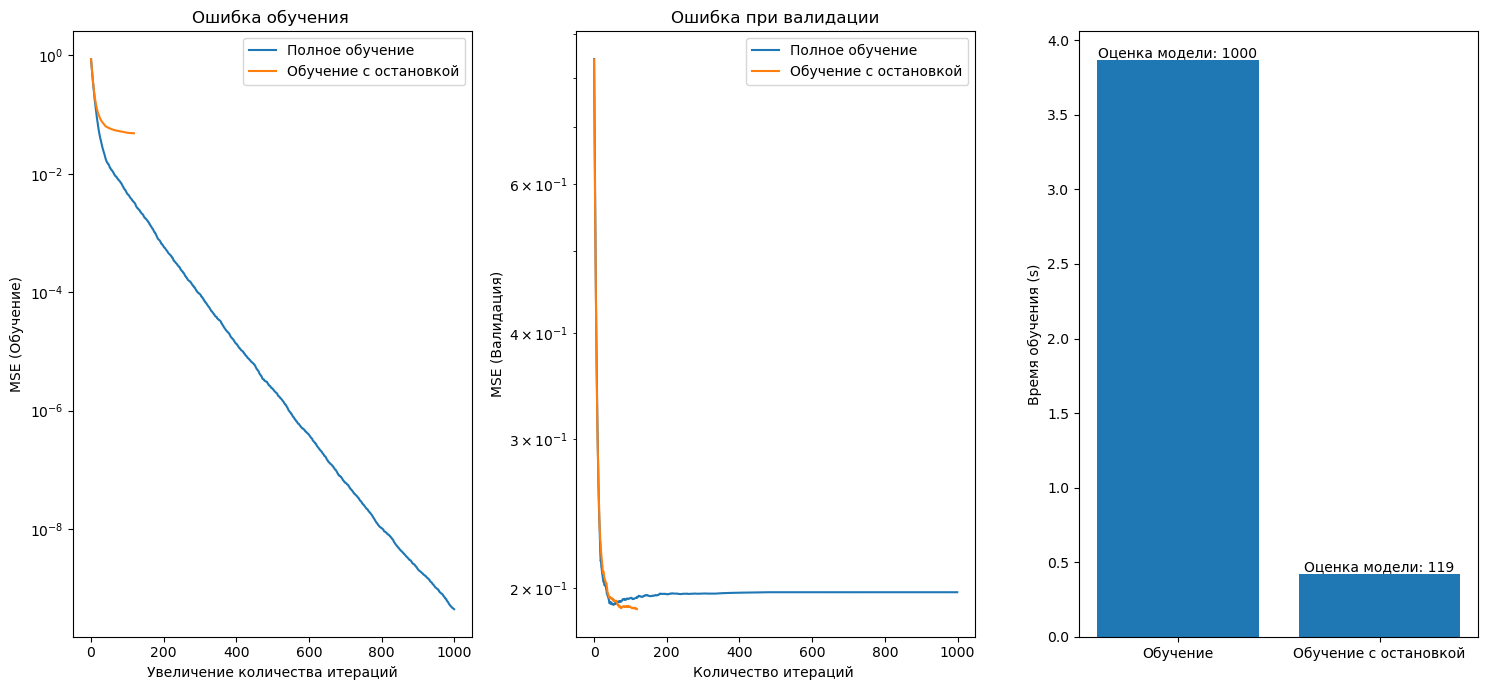

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 7))

axes[0].plot(train_errors_without, label="Полное обучение")
axes[0].plot(train_errors_with, label="Обучение с остановкой")
axes[0].set_xlabel("Увеличение количества итераций")
axes[0].set_ylabel("MSE (Обучение)")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].set_title("Ошибка обучения ")

axes[1].plot(val_errors_without, label="Полное обучение")
axes[1].plot(val_errors_with, label="Обучение с остановкой")
axes[1].set_xlabel("Количество итераций ")
axes[1].set_ylabel("MSE (Валидация)")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Ошибка при валидации")

training_times = [training_time_full, training_time_early_stopping]
labels = ["Обучение", "Обучение с остановкой"]
bars = axes[2].bar(labels, training_times)
axes[2].set_ylabel("Время обучения (s)")

for bar, n_estimators in zip(bars, [n_estimators_full, estimators_early_stopping]):
    height = bar.get_height()
    axes[2].text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.001,
        f"Оценка модели: {n_estimators}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

Разница в ошибке обучения между gbm_full и
`gbm_early_stopping` обусловлен тем фактом, что `gbm_early_stopping` устанавливает
в сторону `validation_fraction` обучающих данных в качестве внутреннего набора проверки.
Решение о досрочной остановке принимается на основе этой внутренней оценки валидации..



## Краткое содержание
В нашем примере с :class:`~sklearn.ensemble.GradientBoostingRegressor`
модели на основе набора данных о ценах на жилье в Калифорнии мы продемонстрировали
практические преимущества ранней остановки:

- **Предотвращение переобучения.** Мы показали, как стабилизируется ошибка проверки.
 или начинает увеличиваться после определенного момента, указывая на то, что модель
 лучше обобщает невидимые данные. Это достигается прекращением обучения.
 процесс до того, как произойдет переобучение.
- **Повышение эффективности обучения.** Мы сравнили время обучения между
 модели с ранней остановкой и без. Модель с ранней остановкой
 достигли сопоставимой точности, требуя при этом значительно меньшего количества
 оценщиков, что приводит к более быстрому обучению.

